In [2]:
import pandas as pd 
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelBinarizer
import joblib
from sklearn.pipeline import Pipeline


In [3]:
# df = pd.read_csv(r'../../resources/dataset_sentimientos_robusto.csv')
# df.head()

In [4]:
splits = {'train': 'data/train-00000-of-00001-b9bddb52d8219a12.parquet', 'test': 'data/test-00000-of-00001-d161e0d7d20a9b0a.parquet'}
df_train = pd.read_parquet("hf://datasets/vg055/analisis-sentimientos-textos-turisitcos-mx-polaridadV3-DA/" + splits["train"])

C:\Users\erik-\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df_train.head()

,text,label
0,La mejor relación calidad-precio Deliciosa com...,5
1,Nos sentimos especiales El 28 de enero era nue...,5
2,"AUSTERO, ANTIGUO, BIEN UBICADO, A UNA CUADRA D...",3
3,Muchas piezas de oro es simplemente increíble ...,5
4,Se cayeron 2 estrellas Cuando vi la calificaci...,3


In [6]:
splits = {'train': 'data/train-00000-of-00001-b9bddb52d8219a12.parquet', 'test': 'data/test-00000-of-00001-d161e0d7d20a9b0a.parquet'}
df_test = pd.read_parquet("hf://datasets/vg055/analisis-sentimientos-textos-turisitcos-mx-polaridadV3-DA/" + splits["test"])

In [7]:
df_test.head()

,text,label
0,Un agradable paseo por el casco antiguo de la ...,5
1,Gran llegar entrada procedente Gran ciudad en ...,4
2,Sencillamente Espectacular Para Caminarlo o en...,5
3,Monserrate y sus bellas vistas Es una visita o...,5
4,Un paraiso muy cerca de la ciudad de Mérida El...,5


In [8]:
df = pd.concat([df_train, df_test], ignore_index=True)
df.head()

,text,label
0,La mejor relación calidad-precio Deliciosa com...,5
1,Nos sentimos especiales El 28 de enero era nue...,5
2,"AUSTERO, ANTIGUO, BIEN UBICADO, A UNA CUADRA D...",3
3,Muchas piezas de oro es simplemente increíble ...,5
4,Se cayeron 2 estrellas Cuando vi la calificaci...,3


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299820 entries, 0 to 299819
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    299820 non-null  object
 1   label   299820 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.6+ MB


In [10]:
df['sentimiento'] = df['label'].map(
    {5: 'Positivo',
     4: 'Positivo',
     3: 'Neutro', 
     2: 'Negativo',
     1: 'Negativo'
    })

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299820 entries, 0 to 299819
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         299820 non-null  object
 1   label        299820 non-null  int64 
 2   sentimiento  299820 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.9+ MB


In [12]:
df = df[['text', 'sentimiento']]
df.head()

,text,sentimiento
0,La mejor relación calidad-precio Deliciosa com...,Positivo
1,Nos sentimos especiales El 28 de enero era nue...,Positivo
2,"AUSTERO, ANTIGUO, BIEN UBICADO, A UNA CUADRA D...",Neutro
3,Muchas piezas de oro es simplemente increíble ...,Positivo
4,Se cayeron 2 estrellas Cuando vi la calificaci...,Neutro


In [13]:
distribucion_sentimentos = round(df['sentimiento'].value_counts(normalize = True)*100,2)
print(distribucion_sentimentos)

sentimiento
Positivo    72.48
Neutro      13.80
Negativo    13.71
Name: proportion, dtype: float64


In [14]:
corpus_entrenamiento, corpus_prueba, y_entrenamiento, y_prueba = train_test_split(
    df['text'],
    df['sentimiento'], 
    test_size=0.2, 
    random_state=42, 
    stratify=df['sentimiento'])

In [15]:
def print_distribution(name, series):
    series = pd.Series(series)
    dist = round(series.value_counts(normalize=True), 2)
    print(f"{name} Distribution:\n{dist}\n")

# Maintains the original Odyssey/Iliad ratio
print_distribution("Distribución Entrenamiento", y_entrenamiento)
print_distribution("Distribución Prueba", y_prueba)

Distribución Entrenamiento Distribution:
sentimiento
Positivo    0.72
Neutro      0.14
Negativo    0.14
Name: proportion, dtype: float64

Distribución Prueba Distribution:
sentimiento
Positivo    0.72
Neutro      0.14
Negativo    0.14
Name: proportion, dtype: float64



In [16]:
# Descargar recursos de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Eliminar stopwords y lematizar
stopword_list = set(stopwords.words('spanish'))

def procesar_texto_español(texto):
    """
    Función para limpiar y preprocesar texto en español.
    """
    # Manejo de valores nulos
    if not isinstance(texto, str):
        return ""
    
    # Eliminar HTML
    texto = BeautifulSoup(texto, "html.parser").get_text()
    
    # Eliminar URLs
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    
    # Convertir a minúsculas
    texto = texto.lower()
    
    # Eliminar emojis
    texto = re.sub(r"[^\w\sáéíóúñü]",
        "",
        texto)
    
    # Tokenizar
    tokens = word_tokenize(texto, language='spanish')
    
    # Eliminar stopwords y lematizar
    tokens_limpios = [token for token in tokens if token not in stopword_list and len(token) > 2]
    return ' '.join(tokens_limpios) 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\erik-\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [17]:
corpus_entrenamiento_normalizado = [procesar_texto_español(text) for text in corpus_entrenamiento]
corpus_prueba_normalizado = [procesar_texto_español(text) for text in corpus_prueba]

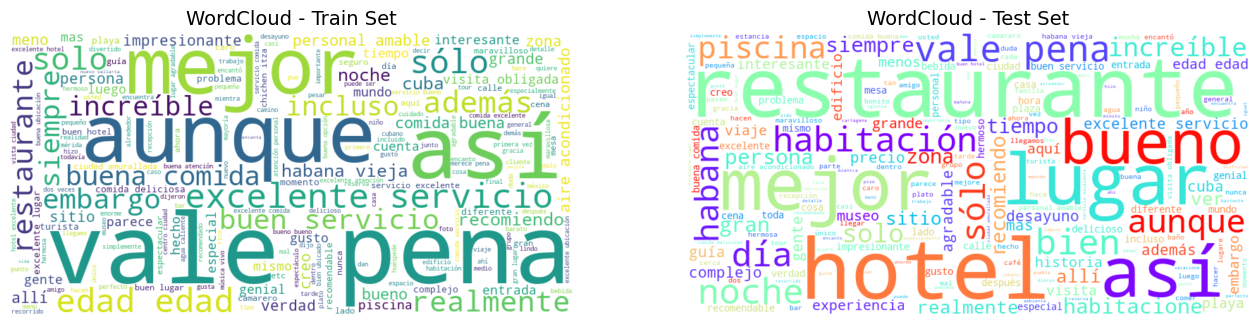

In [18]:
texto_entrenamiento = " ".join(corpus_entrenamiento_normalizado)
texto_prueba = " ".join(corpus_prueba_normalizado)

wc_train = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(texto_entrenamiento)
wc_test = WordCloud(width=800, height=400, background_color="white", colormap="rainbow").generate(texto_prueba)

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.imshow(wc_train, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Train Set", fontsize=14)

plt.subplot(1,2,2)
plt.imshow(wc_test, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Test Set", fontsize=14)

plt.show()

In [19]:
vectorizer = TfidfVectorizer(
    norm= 'l2',
    smooth_idf= True,
    use_idf= True,
    ngram_range= (1,2), 
    max_df= 0.90,
    min_df= 2)

tfidf_matrix_entrenamiento = vectorizer.fit_transform(corpus_entrenamiento_normalizado)
tfidf_matrix_prueba = vectorizer.transform(corpus_prueba_normalizado)


In [20]:
np.unique(y_prueba)

array(['Negativo', 'Neutro', 'Positivo'], dtype=object)

In [21]:
def evaluacion_modelos(y_real, y_pred):
    
    labels = ['Negativo', 'Neutro', 'Positivo']

    print(f'Accuracy: {round(accuracy_score(y_real, y_pred),2)}')
    print(f'Precision: {round(precision_score(y_real, y_pred, average= "weighted"),2)}')
    print(f'F1-Score: {round(f1_score(y_real, y_pred, average= "weighted"),2)}')
    print(f'Recall: {round(recall_score(y_real, y_pred, average= "weighted"),2)}')
    
    matriz_confusion_modelo = confusion_matrix(y_real, y_pred, normalize= "true")
    visualizacion_matriz_confusion = ConfusionMatrixDisplay(matriz_confusion_modelo, display_labels= labels)
    visualizacion_matriz_confusion.plot();
    print(classification_report(y_real, y_pred, target_names= labels))


In [22]:
tfidf_matrix_entrenamiento.shape, tfidf_matrix_prueba.shape

((239856, 884422), (59964, 884422))

In [23]:
modelo_lr = LogisticRegression(
    max_iter= 1000,
    random_state= 42,
    class_weight= 'balanced')

modelo_lr.fit(tfidf_matrix_entrenamiento, y_entrenamiento)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [24]:
y_pred_lr = modelo_lr.predict(tfidf_matrix_prueba)
y_proba_lr = modelo_lr.predict_proba(tfidf_matrix_prueba)

Accuracy: 0.88
Precision: 0.89
F1-Score: 0.89
Recall: 0.88
              precision    recall  f1-score   support

    Negativo       0.84      0.88      0.86      8224
      Neutro       0.59      0.72      0.65      8276
    Positivo       0.96      0.91      0.94     43464

    accuracy                           0.88     59964
   macro avg       0.80      0.84      0.81     59964
weighted avg       0.89      0.88      0.89     59964



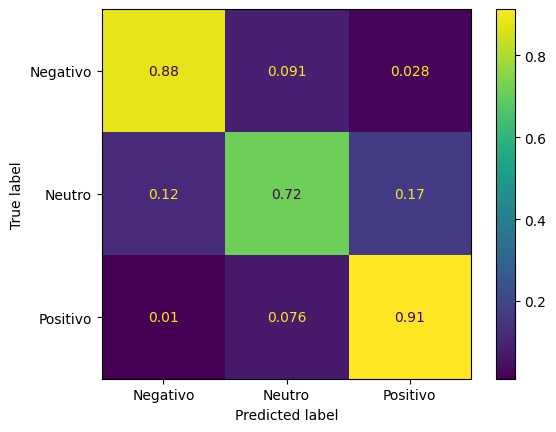

In [25]:
evaluacion_modelos(y_prueba,y_pred_lr)

In [26]:
modelo_nb = MultinomialNB(alpha = 1.0)
modelo_nb.fit(tfidf_matrix_entrenamiento,y_entrenamiento)

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


In [27]:
y_pred_nb = modelo_nb.predict(tfidf_matrix_prueba)

Accuracy: 0.78
Precision: 0.82
F1-Score: 0.71
Recall: 0.78
              precision    recall  f1-score   support

    Negativo       0.95      0.38      0.55      8224
      Neutro       0.98      0.03      0.05      8276
    Positivo       0.77      1.00      0.87     43464

    accuracy                           0.78     59964
   macro avg       0.90      0.47      0.49     59964
weighted avg       0.82      0.78      0.71     59964



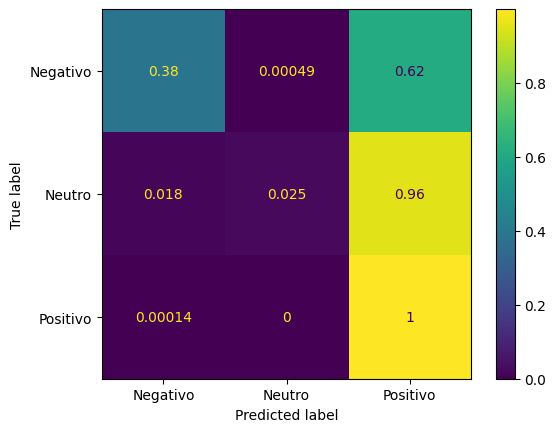

In [28]:
evaluacion_modelos(y_prueba,y_pred_nb)

In [29]:
modelos = {
    'Logistic Regression': y_pred_lr,
    'Naive Bayes': y_pred_nb
}

resultados = []

for nombre, pred in modelos.items():
    acc = accuracy_score(y_prueba, pred)
    prec = precision_score(y_prueba, pred, average='weighted')
    rec = recall_score(y_prueba, pred, average='weighted')
    f1 = f1_score(y_prueba, pred, average='weighted')
    
    resultados.append({
        'Modelo': nombre,
        'Exactitud': round(acc, 3),
        'Precisión': round(prec, 3),
        'Recall': round(rec, 3),
        'F1 Score': round(f1, 3)
    })

tabla_resultados = pd.DataFrame(resultados)

tabla_resultados.sort_values(by='Exactitud', ascending=False, inplace=True)
display(tabla_resultados)

,Modelo,Exactitud,Precisión,Recall,F1 Score
0,Logistic Regression,0.881,0.893,0.881,0.886
1,Naive Bayes,0.781,0.824,0.781,0.712


In [30]:
# Obtener coeficientes
feature_names = np.array(vectorizer.get_feature_names_out())
clases = modelo_lr.classes_

for i, clase in enumerate(clases):
    print(f"\n{'='*30}")
    print(f"SENTIMIENTO: {clase}")
    print(f"{'='*30}")
    
    # Top 15 palabras más importantes
    coefs = modelo_lr.coef_[i]
    top_indices = np.argsort(coefs)[-15:][::-1]
    top_features = feature_names[top_indices]
    top_coefs = coefs[top_indices]
    
    for feature, coef in zip(top_features, top_coefs):
        print(f"{feature:20s}: {coef:.4f}")


SENTIMIENTO: Negativo
peor                : 10.1532
mala                : 8.4522
horrible            : 8.1862
usted               : 7.7282
mal                 : 7.5006
terrible            : 7.4699
decepción           : 7.1972
sucio               : 5.8053
decepcionante       : 5.7295
pésimo              : 5.0181
cucarachas          : 5.0115
malo                : 4.9956
único bueno         : 4.9396
decepcionado        : 4.7571
sucias              : 4.4688

SENTIMIENTO: Neutro
normal              : 7.2623
regular             : 5.4725
embargo             : 4.7269
carece              : 4.6147
esperaba            : 4.3166
promedio            : 4.2595
desafortunadamente  : 3.6374
normalito           : 3.4192
aceptable           : 3.1699
necesita            : 3.0442
buena               : 3.0061
antigua habana      : 2.9763
similares           : 2.9261
áreas               : 2.9238
mejorar             : 2.8289

SENTIMIENTO: Positivo
excelente           : 15.5750
increíble           : 8.3890
enc

In [31]:
# Función para predecir
def predecir_sentimiento(texto, modelo=modelo_lr, vectorizer=vectorizer):
    # Vectorizar
    texto_tfidf = vectorizer.transform([texto])
    
    # Predecir
    prediccion = modelo.predict(texto_tfidf)[0]
    probabilidades = modelo.predict_proba(texto_tfidf)[0]
    
    # Crear resultado
    resultado = {
        'texto': texto,
        'sentimiento': prediccion,
        'probabilidad': max(probabilidades),
        'probabilidades_detalle': dict(zip(modelo.classes_, probabilidades))
    }
    
    return resultado

In [32]:
ejemplos = [
    "Excelente servicio, muy recomendado!",
    "Pésima experiencia, no lo recomiendo para nada",
    "Es un producto normal, nada especial",
    "HORRIBLE!!! No funciona y nadie responde",
    "Me encantó, superó mis expectativas completamente",
    "Está bien para el precio que pagué"
]

for ejemplo in ejemplos:
    resultado = predecir_sentimiento(ejemplo)
    print(f"\nTexto: {resultado['texto']}")
    print(f"Predicción: {resultado['sentimiento']}")
    print(f"Confianza: {resultado['probabilidad']:.2%}")
    print(f"Probabilidades: {resultado['probabilidades_detalle']}")
    print("-" * 60)


Texto: Excelente servicio, muy recomendado!
Predicción: Positivo
Confianza: 100.00%
Probabilidades: {'Negativo': np.float64(1.7887841720618316e-06), 'Neutro': np.float64(5.0523575792699135e-06), 'Positivo': np.float64(0.9999931588582488)}
------------------------------------------------------------

Texto: Pésima experiencia, no lo recomiendo para nada
Predicción: Negativo
Confianza: 99.27%
Probabilidades: {'Negativo': np.float64(0.9927400288868993), 'Neutro': np.float64(0.001554090490079738), 'Positivo': np.float64(0.005705880623020968)}
------------------------------------------------------------

Texto: Es un producto normal, nada especial
Predicción: Neutro
Confianza: 85.11%
Probabilidades: {'Negativo': np.float64(0.14452622343437674), 'Neutro': np.float64(0.8510694771083588), 'Positivo': np.float64(0.004404299457264441)}
------------------------------------------------------------

Texto: HORRIBLE!!! No funciona y nadie responde
Predicción: Negativo
Confianza: 99.58%
Probabilidad

In [ ]:
joblib.dump(modelo_lr, "modelo_sentimientos_español.pkl")
joblib.dump(vectorizer, "tfidf_vectorizador_español.pkl")

['tfidf_vectorizador.pkl']

In [ ]:

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('modelo', LogisticRegression(max_iter=1000))
])

pipeline.fit(df['text'], df['sentimiento'])
joblib.dump(pipeline, "pipeline_sentimientos_español.pkl")


['pipeline_sentimientos.pkl']